# Lite Architecture Experiment Results

In [155]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.stats.api as sms

from db import conn

In [156]:
%matplotlib inline

In [157]:
sns.set_style("whitegrid")

In [158]:
cursor = conn.cursor()
experiment_rows = [r for r in cursor.execute("""
    select g.name, args, dev_metric, test_metric from experiments e
    join experiment_groups g on e.group_id=g.gid
    where g.name=?""", ('mpcnn-v2-lite-fix-params-and-seed',))]

In [159]:
len(experiment_rows)

150

In [160]:
experiment_results = {
    'trecqa': [],
    'wikiqa': [],
    'sick': []
}

for row in experiment_rows:
    args = json.loads(row[1])
    dev_metrics = json.loads(row[2])
    test_metrics = json.loads(row[3])
    dataset = args['dataset']
    
    if args['arch'] == 'mpcnn_no_per_dim_no_multi_pooling':
        arch = 'MP-CNN Lite'
    elif args['arch'] == 'mpcnn_no_per_dim_no_multi_pooling_no_horiz' or args['arch'] == 'mpcnn_no_per_dim_no_multi_pooling_no_horiz_no_inf':
        continue
    elif args['arch'] == 'smcnn_with_comp':
        arch = 'SM-CNN with Comp'
    else:
        arch = 'MP-CNN'
    
    res_base = {
        'arch': arch,
        'dataset': dataset,
        'seed': args['seed']
    }
    
    results = []
    
    if dataset in ('trecqa', 'wikiqa'):
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MAP', 'metric_val': dev_metrics['map']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'MRR', 'metric_val': dev_metrics['mrr']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MAP', 'metric_val': test_metrics['map']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'MRR', 'metric_val': test_metrics['mrr']}})
    elif dataset == 'sick':
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'pearson', 'metric_val': dev_metrics['pearson']}})
        results.append({**res_base, **{'split': 'dev', 'metric_name': 'spearman', 'metric_val': dev_metrics['spearman']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'pearson', 'metric_val': test_metrics['pearson']}})
        results.append({**res_base, **{'split': 'test', 'metric_name': 'spearman', 'metric_val': test_metrics['spearman']}})
    
    experiment_results[dataset].extend(results)

In [161]:
trecqa = pd.DataFrame(experiment_results['trecqa'])
wikiqa = pd.DataFrame(experiment_results['wikiqa'])
sick = pd.DataFrame(experiment_results['sick'])

In [162]:
trecqa['arch'].unique()

array(['MP-CNN', 'MP-CNN Lite', 'SM-CNN with Comp'], dtype=object)

In [163]:
archs = ['MP-CNN', 'MP-CNN Lite', 'SM-CNN with Comp']
def compare_change_to_baseline(df, metric):
    config_ids = df['seed'].unique()
    for arch in archs:
        diffs = []
        for config_id in config_ids:
            baseline = df[(df['seed'] == config_id) & (df['arch'] == 'MP-CNN')].iloc[0]['metric_val']
            conf_perf = df[(df['seed'] == config_id) & (df['arch'] == arch)].iloc[0]['metric_val']
            diffs.append(conf_perf - baseline)

        print(f'Architecture: {arch}')
        print(f'Median of {metric} change compared with single baseline: {np.median(diffs):.4f}')
        print(f'Mean of {metric} change compared with single baseline: {np.mean(diffs):.4f}')

## TrecQA

In [164]:
trec_map_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'test')]
trec_mrr_vs_archs_test = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'test')]
trec_map_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MAP') & (trecqa['split'] == 'dev')]
trec_mrr_vs_archs_dev = trecqa[(trecqa['metric_name'] == 'MRR') & (trecqa['split'] == 'dev')]

In [165]:
for arch in trec_map_vs_archs_test['arch'].unique():
    arr = trec_map_vs_archs_test[trec_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7252, 0.8184)
MP-CNN Lite: (0.7561, 0.7840)
SM-CNN with Comp: (0.6644, 0.6808)


In [166]:
for arch in trec_mrr_vs_archs_test['arch'].unique():
    arr = trec_mrr_vs_archs_test[trec_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.7550, 0.8406)
MP-CNN Lite: (0.8299, 0.8550)
SM-CNN with Comp: (0.7553, 0.7788)


In [167]:
trec_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.77179,461056.7
MP-CNN Lite,0.77006,461056.7
SM-CNN with Comp,0.67263,461056.7


In [168]:
trec_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.79778,461056.7
MP-CNN Lite,0.84248,461056.7
SM-CNN with Comp,0.76703,461056.7


In [169]:
trec_map_vs_archs_test.sort_values('seed')

,arch,dataset,metric_name,metric_val,seed,split
98,SM-CNN with Comp,trecqa,MAP,0.6749,15137,test
38,MP-CNN Lite,trecqa,MAP,0.7691,15137,test
34,MP-CNN,trecqa,MAP,0.8158,15137,test
118,SM-CNN with Comp,trecqa,MAP,0.6449,60085,test
78,MP-CNN Lite,trecqa,MAP,0.7757,60085,test
74,MP-CNN,trecqa,MAP,0.8028,60085,test
82,SM-CNN with Comp,trecqa,MAP,0.6723,286404,test
2,MP-CNN,trecqa,MAP,0.6996,286404,test
6,MP-CNN Lite,trecqa,MAP,0.7759,286404,test
18,MP-CNN,trecqa,MAP,0.6147,307476,test


In [170]:
compare_change_to_baseline(trec_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: -0.0245
Mean of MAP change compared with single baseline: -0.0017
Architecture: SM-CNN with Comp
Median of MAP change compared with single baseline: -0.1256
Mean of MAP change compared with single baseline: -0.0992


In [171]:
compare_change_to_baseline(trec_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: 0.0388
Mean of MRR change compared with single baseline: 0.0447
Architecture: SM-CNN with Comp
Median of MRR change compared with single baseline: -0.0356
Mean of MRR change compared with single baseline: -0.0307


## WikiQA

In [172]:
wikiqa_map_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'test')]
wikiqa_mrr_vs_archs_test = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'test')]
wikiqa_map_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MAP') & (wikiqa['split'] == 'dev')]
wikiqa_mrr_vs_archs_dev = wikiqa[(wikiqa['metric_name'] == 'MRR') & (wikiqa['split'] == 'dev')]

In [173]:
for arch in wikiqa_map_vs_archs_test['arch'].unique():
    arr = wikiqa_map_vs_archs_test[wikiqa_map_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.5796, 0.6868)
MP-CNN Lite: (0.6815, 0.7009)
SM-CNN with Comp: (0.6449, 0.6577)


In [174]:
for arch in wikiqa_mrr_vs_archs_test['arch'].unique():
    arr = wikiqa_mrr_vs_archs_test[wikiqa_mrr_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.5803, 0.6957)
MP-CNN Lite: (0.6969, 0.7143)
SM-CNN with Comp: (0.6609, 0.6730)


In [175]:
wikiqa_map_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.63322,461056.7
MP-CNN Lite,0.69120,461056.7
SM-CNN with Comp,0.65126,461056.7


In [176]:
wikiqa_mrr_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.63803,461056.7
MP-CNN Lite,0.70564,461056.7
SM-CNN with Comp,0.66692,461056.7


In [177]:
compare_change_to_baseline(wikiqa_map_vs_archs_test, 'MAP')

Architecture: MP-CNN
Median of MAP change compared with single baseline: 0.0000
Mean of MAP change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MAP change compared with single baseline: 0.0916
Mean of MAP change compared with single baseline: 0.0580
Architecture: SM-CNN with Comp
Median of MAP change compared with single baseline: 0.0476
Mean of MAP change compared with single baseline: 0.0180


In [178]:
compare_change_to_baseline(wikiqa_mrr_vs_archs_test, 'MRR')

Architecture: MP-CNN
Median of MRR change compared with single baseline: 0.0000
Mean of MRR change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of MRR change compared with single baseline: 0.1050
Mean of MRR change compared with single baseline: 0.0676
Architecture: SM-CNN with Comp
Median of MRR change compared with single baseline: 0.0634
Mean of MRR change compared with single baseline: 0.0289


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85]),
 <a list of 10 Text yticklabel objects>)

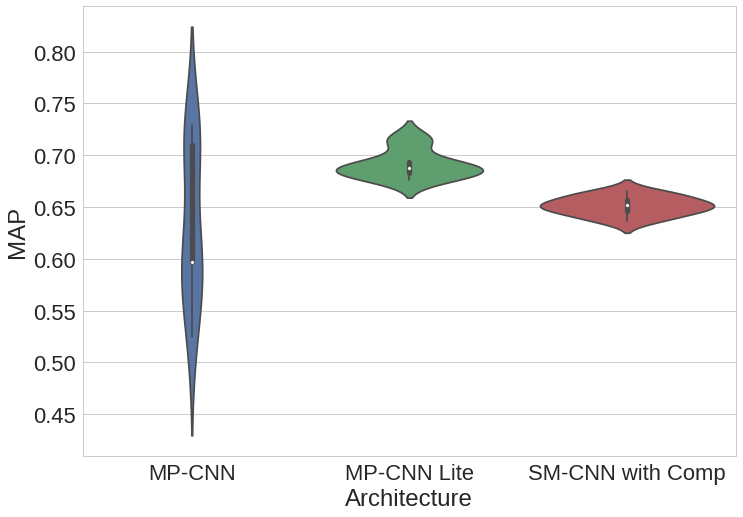

In [179]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('MAP', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.6, 0.75)

## SICK

In [180]:
sick_pearson_vs_archs_test = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'test')]
sick_spearman_vs_archs_test = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'test')]
sick_pearson_vs_archs_dev = sick[(sick['metric_name'] == 'pearson') & (sick['split'] == 'dev')]
sick_spearman_vs_archs_dev = sick[(sick['metric_name'] == 'spearman') & (sick['split'] == 'dev')]

In [181]:
for arch in sick_pearson_vs_archs_test['arch'].unique():
    arr = sick_pearson_vs_archs_test[sick_pearson_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.8327, 0.8829)
MP-CNN Lite: (0.8637, 0.8716)
SM-CNN with Comp: (0.8211, 0.8290)


In [182]:
for arch in sick_spearman_vs_archs_test['arch'].unique():
    arr = sick_spearman_vs_archs_test[sick_spearman_vs_archs_test['arch'] == arch]['metric_val']
    ci = sms.DescrStatsW(arr).tconfint_mean()
    print(f'{arch}: ({ci[0]:.4f}, {ci[1]:.4f})')

MP-CNN: (0.8025, 0.8126)
MP-CNN Lite: (0.7995, 0.8102)
SM-CNN with Comp: (0.7616, 0.7680)


In [183]:
sick_pearson_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.857814,461056.7
MP-CNN Lite,0.867667,461056.7
SM-CNN with Comp,0.825047,461056.7


In [184]:
sick_spearman_vs_archs_test.groupby('arch').mean()

,metric_val,seed
arch,,
MP-CNN,0.807525,461056.7
MP-CNN Lite,0.804877,461056.7
SM-CNN with Comp,0.764806,461056.7


In [185]:
compare_change_to_baseline(sick_pearson_vs_archs_test, 'pearson')

Architecture: MP-CNN
Median of pearson change compared with single baseline: 0.0000
Mean of pearson change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of pearson change compared with single baseline: -0.0022
Mean of pearson change compared with single baseline: 0.0099
Architecture: SM-CNN with Comp
Median of pearson change compared with single baseline: -0.0432
Mean of pearson change compared with single baseline: -0.0328


In [186]:
compare_change_to_baseline(sick_spearman_vs_archs_test, 'spearman')

Architecture: MP-CNN
Median of spearman change compared with single baseline: 0.0000
Mean of spearman change compared with single baseline: 0.0000
Architecture: MP-CNN Lite
Median of spearman change compared with single baseline: -0.0055
Mean of spearman change compared with single baseline: -0.0026
Architecture: SM-CNN with Comp
Median of spearman change compared with single baseline: -0.0432
Mean of spearman change compared with single baseline: -0.0427


/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(array([ 0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95]),
 <a list of 6 Text yticklabel objects>)

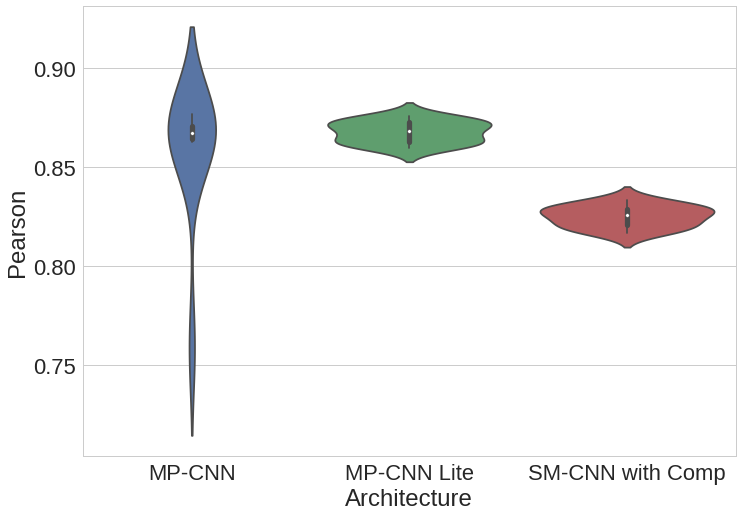

In [187]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.xlabel('Architecture', fontsize=24)
plt.ylabel('Pearson', fontsize=24)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
# plt.ylim(0.86, 0.88)

/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/u3/z3tu/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


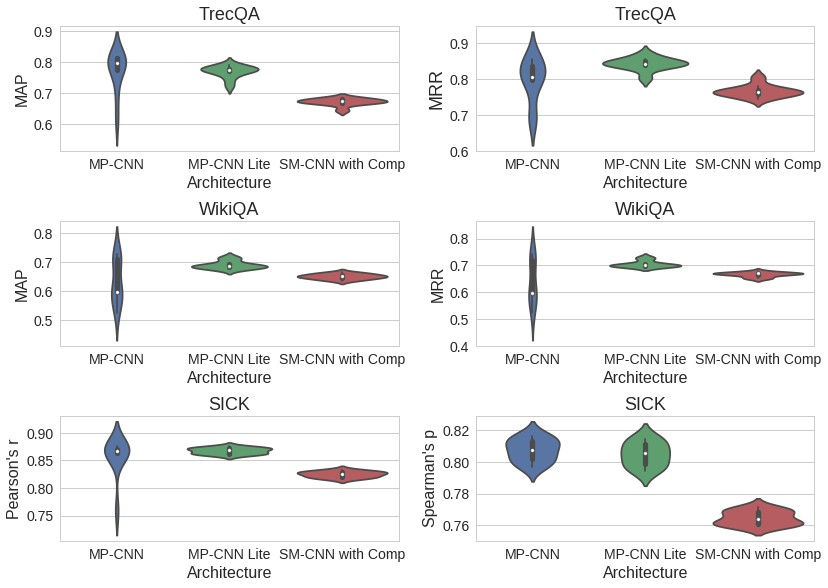

In [188]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
title_size = 18
axis_size = 16
tick_size = 14

ax = plt.subplot(321)
sns.violinplot(x='arch', y='metric_val', data=trec_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(322)
sns.violinplot(x='arch', y='metric_val', data=trec_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=18)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('TrecQA', fontsize=title_size)

ax = plt.subplot(323)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_map_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MAP', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(324)
sns.violinplot(x='arch', y='metric_val', data=wikiqa_mrr_vs_archs_test, order=archs, ax=ax)
plt.ylabel('MRR', fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('WikiQA', fontsize=title_size)

ax = plt.subplot(325)
sns.violinplot(x='arch', y='metric_val', data=sick_pearson_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Pearson's r", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)

ax = plt.subplot(326)
sns.violinplot(x='arch', y='metric_val', data=sick_spearman_vs_archs_test, order=archs, ax=ax)
plt.ylabel("Spearman's p", fontsize=axis_size)
plt.xlabel('Architecture', fontsize=axis_size)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.title('SICK', fontsize=title_size)
plt.tight_layout()

plt.savefig('lite-model-violin.pdf')